<a href="https://colab.research.google.com/github/erc-kluijtmans/Machine-Learning/blob/master/Simple_Transformer_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources
https://github.com/huggingface/blog/blob/main/notebooks/02_how_to_generate.ipynb





https://www.youtube.com/watch?v=-QH8fRhqFHM&ab_channel=JayAlammar

https://christianjmills.com/posts/transformers-book-notes/chapter-5/index.html

https://towardsdatascience.com/the-three-decoding-methods-for-nlp-23ca59cb1e9d

https://www.surgehq.ai/blog/introduction-to-reinforcement-learning-with-human-feedback-rlhf-series-part-1

https://www.economist.com/interactive/science-and-technology/2023/04/22/large-creative-ai-models-will-transform-how-we-live-and-work


#1-GPT Time Line

Before we dive deep into the actual mechanism of ChatGPT, let’s take a quick look at the timeline of the development of the transformer architecture of language models and the different versions of GPT, so that you can have a better sense of how things evolved into the ChatGPT we have today.

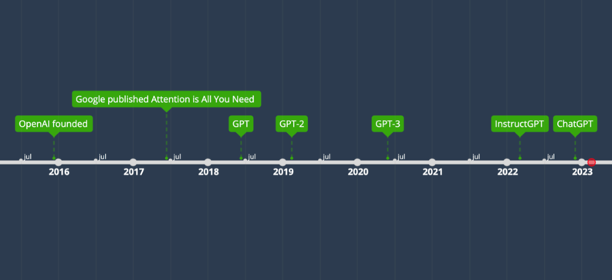

The timeline shows that GPT evolved from the original transformer architecture and gained its ability through many iterations.

#2-GPT Deep Dive

Lets start with the installation of GPT2. Not the latest GPT model but mostly for the ease of installation and computing power ... and good enough to illustrate GPT deep dive!

In [ ]:
!pip install transformers

In [ ]:
!pip install ecco
import ecco

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2',pad_token_id=tokenizer.eos_token_id)


The basic concept of ChatGPT is at some level rather simple. Start from a huge sample of human-created text from the web, books, etc. Then train a neural net to generate text that’s “like this”. And in particular, make it able to start from a “prompt” and then continue with text that’s “like what it’s been trained with”.



And yes, GPT models are giantic neural net (billions of parameters). And it is a particular neural net family set up to deal with language. 

##2-1 From Text to tokens

Using larget datset and machine learning does not give computers the ability to understand language. All these LMs are trained to predict words (or charcaters or sentences). Deep learning models can only process numeric values: they can’t take raw text as input. Vectorizing text is the process of transforming text into numericals. Text vectorization processes come in many shapes and forms, but they all follow the same template:

*   First, you standardize the text to make it easier to process, such as by 
converting it to lowercase or removing punctuation.
*   You split the text into units (called **tokens**), such as characters, words, or groups of words. This is called tokenization. Additionally, stemming (removing suffixes or prefixes), removing stop words, correcting spelling, are also used. For example, “Tom likes to eat pizza.” would be tokenized into [“Tom”, “likes”, “to”, “eat”, “pizza”, “.”] and stemmed into [“Tom”, “like”, “to”, “eat”, “pizza”, “.”].
*   You convert each such token into a numerical vector. This will usually involve first indexing all tokens present in the data. A numerical vector is also called **embedding**. An embedding is defined as a representation of a word and encodes the meaning of the word in such a way that words that are closer in the vector space are expected to be similar in meaning.

Example of Tokenization - Fig.1
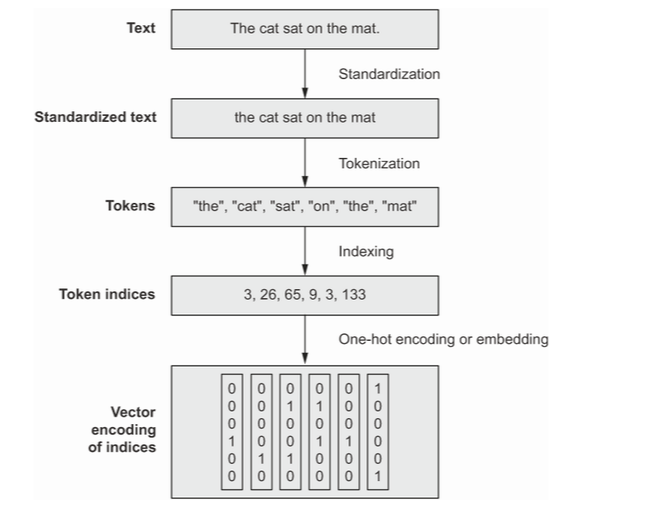


Lets look at an example of tokenization and respective tokens:

In [ ]:
input_txt = "The train has left the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"]
tokenizer.convert_ids_to_tokens(input_ids[0])

And here is the corresponding Token indices (token ids):

In [ ]:
# Print the input token ids
text = "Transformers are the"
input = tokenizer(text, return_tensors="pt")['input_ids']
input

We can take a look at one of the embeddings:

In [ ]:
# Get the embedding vector of token # 464 ('Transform')
model.transformer.wte(torch.tensor(41762))

Every token is coded as a numerical vector of 768 dimensions.

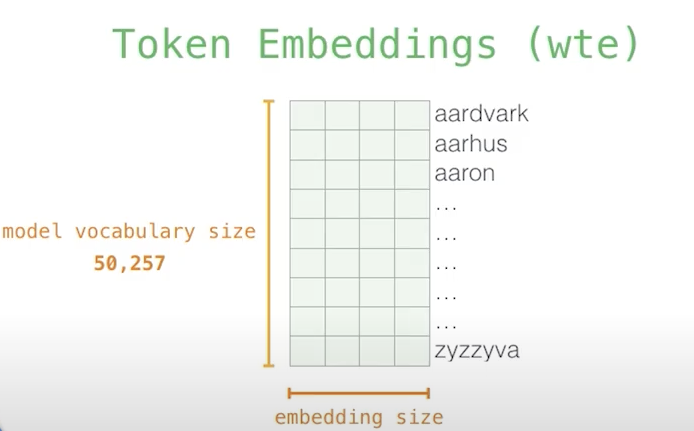

## 2-2 From Embeddings to Context Aware Embeddings

You’ve just learned about word embeddings—vector spaces that capture the “shape” of the semantic relationships between different words. In an embedding space, a single word has a fixed position—a fixed set of relationships with every other word in the **space**

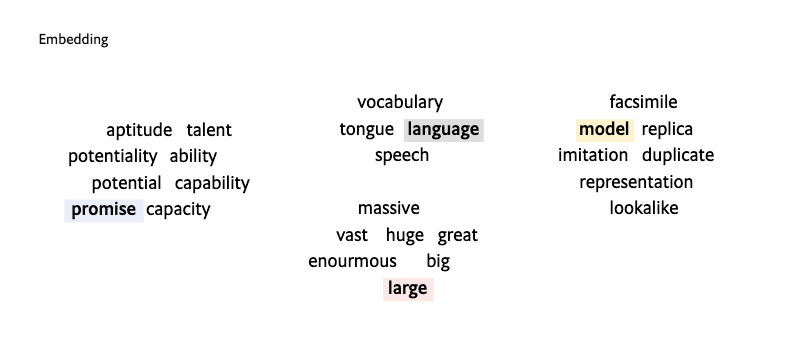

But that’s not quite how language works: the meaning of a word is usually context-specific. When you mark the date, you’re not talking about the same “date” as when you go on a date, nor is it the kind of date you’d buy at the market. When you say, “I’ll see you soon,” the meaning of the word “see” is subtly different from the “see” in “I’ll see this project to its end” or “I see what you mean.” And, of course, the meaning of pronouns like “he,” “it,” “in,” etc., is entirely sentence-specific and can even change multiple times within a single sentence.

So in order for GPT to be precise, it needs to take into account every word of the input, using attention layer. GPT feeds embeddings into a layer (the context aware or attention Layer) that creates a new embedding for each token to incorporate the context of the prompt. For instance, words ‘left’ and ‘trains’ are associated to a facility where trains stop and start when both words are in the prompt. The resulting embedding is a new representation for “train”: a representation that incorporates the surrounding context.

The idea behind the attention layer it is that there might be relevant information in every word in a sentence. . The purpose of self-attention is to tell the model how these tokens are related by using a similarity score. This produces context-aware token representations. Consider the following prompt: “The train left the station on time.” Now, consider one word in the sentence: station. What kind of station are we talking about? Could it be a radio station? Maybe the International Space Station? The resulting embedding is the new representation for “station”: a representation that incorporates the surrounding context. In particular, it includes part of the “train” embedding, clarifying that it is, in fact, a “train station.”

###Self Attention

The purpose of self-attention is to modulate the representation of a token by using the representations of related tokens in the sequence. This produces context-aware token representations. 
Consider an example sentence: **“The train left the station on time.”** 

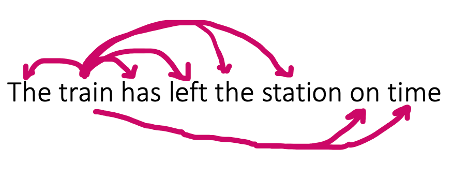

The attention mechanism measures the relevance/similarity between each token. 


 

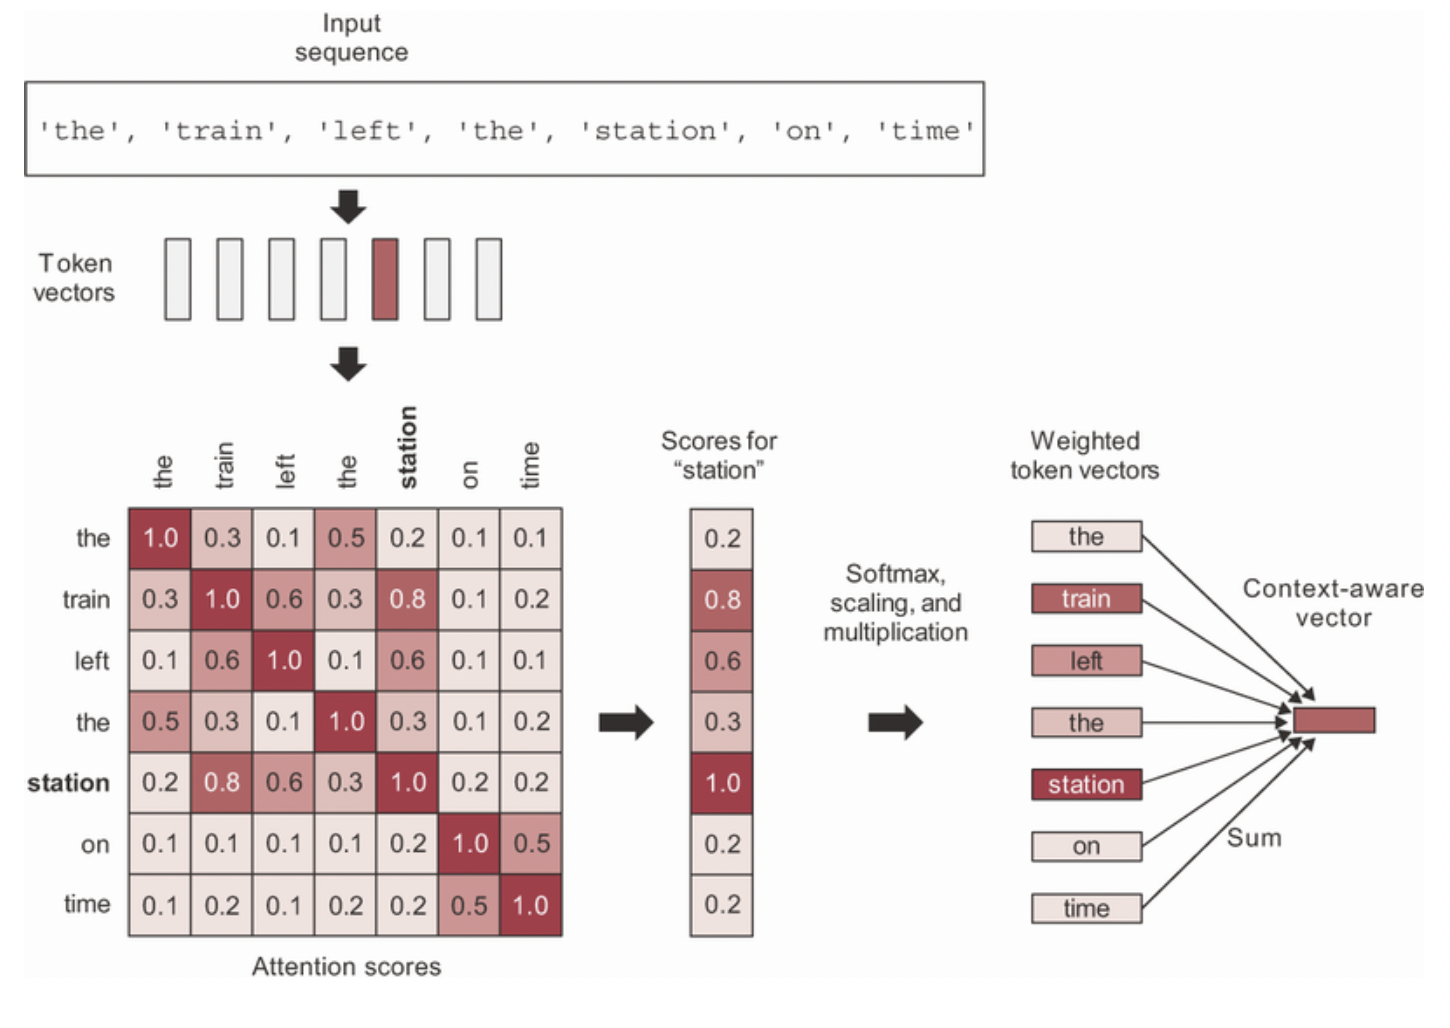

**Step 1** is to compute relevancy scores between the vector for “station” and every other word in the sentence. These are our “attention scores.” We’re simply going to use the dot product between two word vectors as a measure of the strength of their relationship. It’s a very computationally efficient distance function, and it was already the standard way to relate two word embeddings to each other long before Transformers. In practice, these scores will also go through a scaling function and a softmax, but for now, that’s just an implementation detail.
**Step 2** is to compute the sum of all word vectors in the sentence, weighted by our relevancy scores. Words closely related to “station” will contribute more to the sum (including the word “station” itself), while irrelevant words will contribute almost nothing. The resulting vector is our new representation for “station”: a representation that incorporates the surrounding context. In particular, it includes part of the “train” vector, clarifying that it is, in fact, a “train station.”

You’d repeat this process for every word in the sentence, producing a new sequence of vectors encoding the sentence.

## 2-3 FNN

GPT’s full name is Generative Pre-trained Transformer. meaning that it is a type of transformer using only the decode stack - nregular tranformers use both cencoder and decode stack. The encoder and decoder are the main components of transformer architecture. The encoder is responsible for analyzing and “understanding” the input text and decoders are responsible for predicting the next token in the sequence. You can think of decoders like free-form writing — they write based on what you’ve written and what they’ve read, without caring about what they’re going to write.

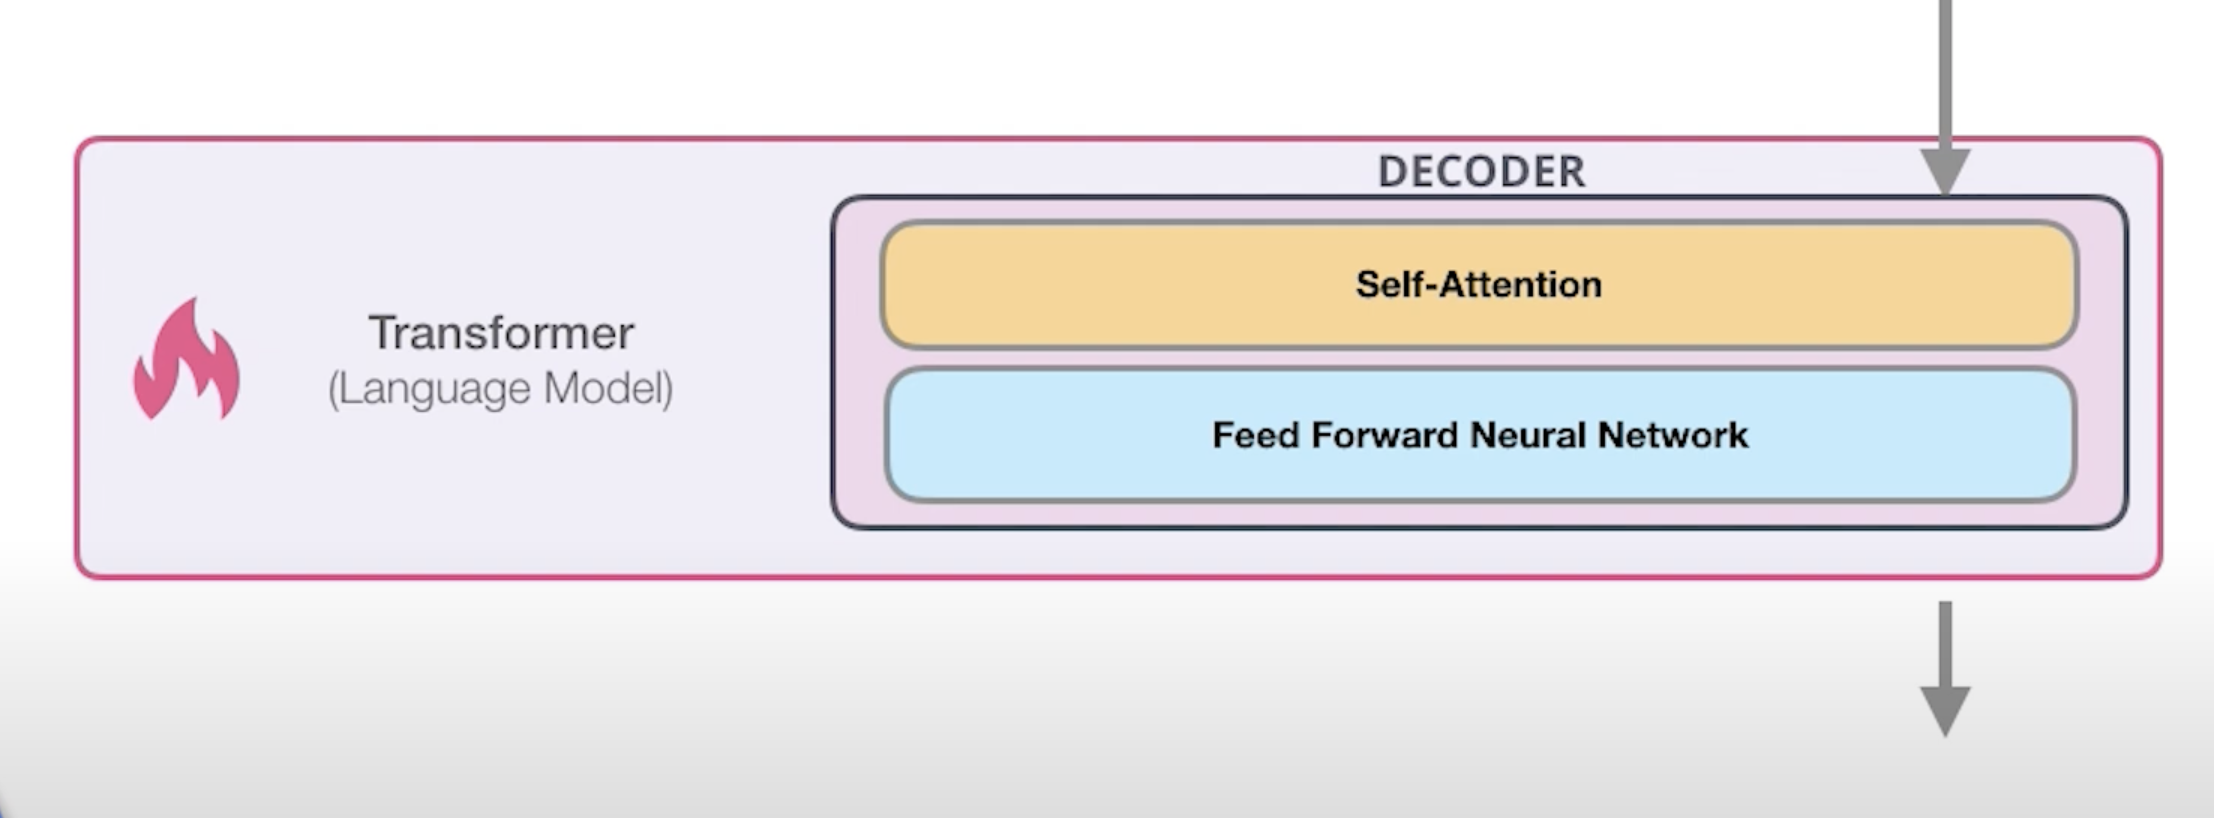

GPT feeds embeddings from the previous layer into the neural net which calculates probabilities for each embedded token part of the vocabulary for what the next token should be. The word associated with the best token is produced as the output for this time step. Be aware that second and third stage form one decoder block and GPT3 is made of 96 decoder blocks.

In [ ]:
import ecco
lm = ecco.from_pretrained('gpt2', verbose=False)
prompt=""" The train has left the"""

output = lm.generate(prompt, generate=1, do_sample=False, attribution=['ig'])
output.primary_attributions(attr_method='ig')

By looking at the hidden states produced by every transformer decoder block, we aim to gleam information about how a language model arrived at a specific output token

Viewing the evolution of the hidden states means that instead of looking only at the candidates output tokens from projecting the final model state, we can look at the top scoring tokens after projecting the hidden state resulting from each of the model's layers.

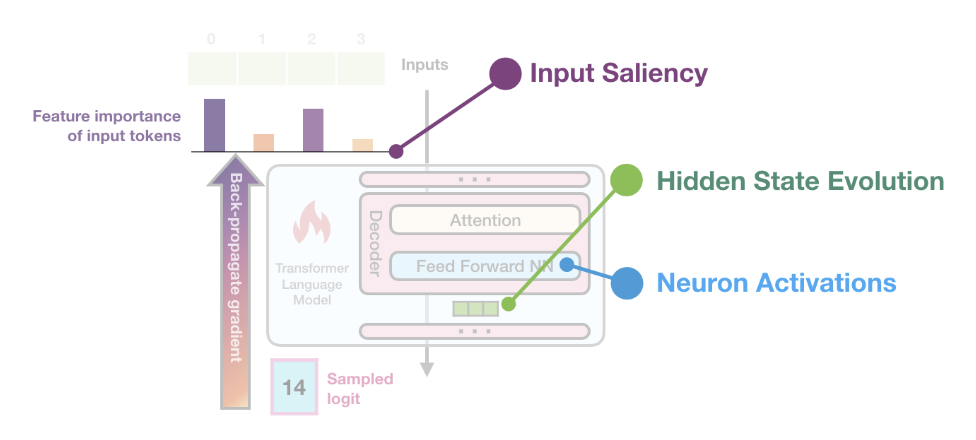

In [ ]:
output.layer_predictions(position=5, topk=10, layer=None)

<IPython.core.display.Javascript object>

Another visual perspective on the evolving hidden states is to re-examine the hidden states after selecting an output token to see how the hidden state after each layer ranked that token.

/usr/local/lib/python3.8/dist-packages/ecco/output.py:469: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_id = torch.tensor(self.token_ids[0][offset + j])


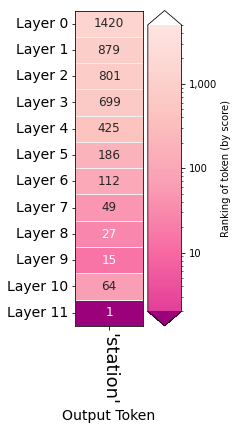

In [ ]:
output.rankings()

In [ ]:
text = "The train has left the"

# Tokenize the input string
input = tokenizer.encode(text, return_tensors="pt")

# Run the model
output = model.generate(input, max_length=20, do_sample=False)

# Print the output
print('\n',tokenizer.decode(output[0]))


 The train has left the station and is now heading to the airport.

The train has left


In [ ]:
model. transformer.wte

Embedding(50257, 768)

The model we use contains 50257 tokens and each token is coded with an embedding of 768 dimensions.

## From words to vectors and back

In [ ]:
# Print the token ides (of the input and output)
output

tensor([[41762,   364,   389,   262,   749,  2219,  2099,   286, 18758,    13,
          1119,   389, 13160,   286,   257,  1271,   286,  1180, 13166,    11]])

In [ ]:
input_txt = "The train has left the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"]
tokenizer.convert_ids_to_tokens(input_ids[0])

['The', 'Ġtrain', 'Ġhas', 'Ġleft', 'Ġthe']

In [ ]:
# Print the input token ids
text = "Transformers are the"
input = tokenizer(text, return_tensors="pt")['input_ids']
input

tensor([[41762,   364,   389,   262]])

In [ ]:
# Get the embedding vector of token # 464 ('Transform')
model.transformer.wte(torch.tensor(41762))

###Transformer Block (Decoder)

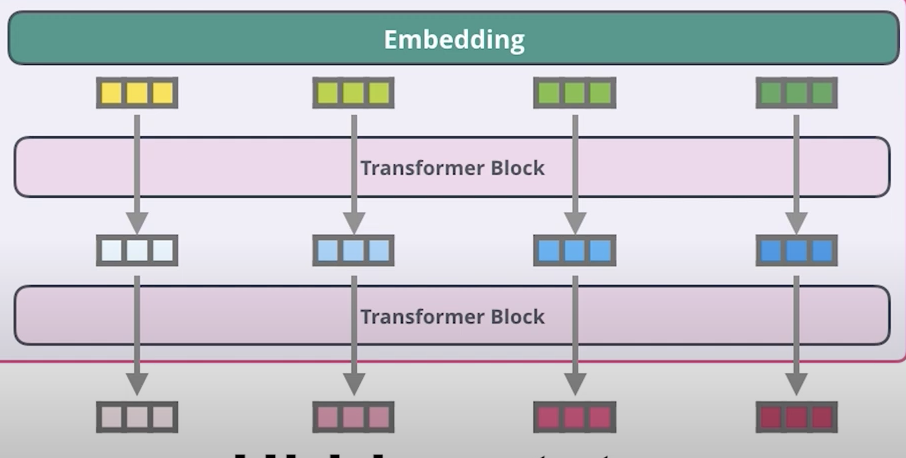

Station was 

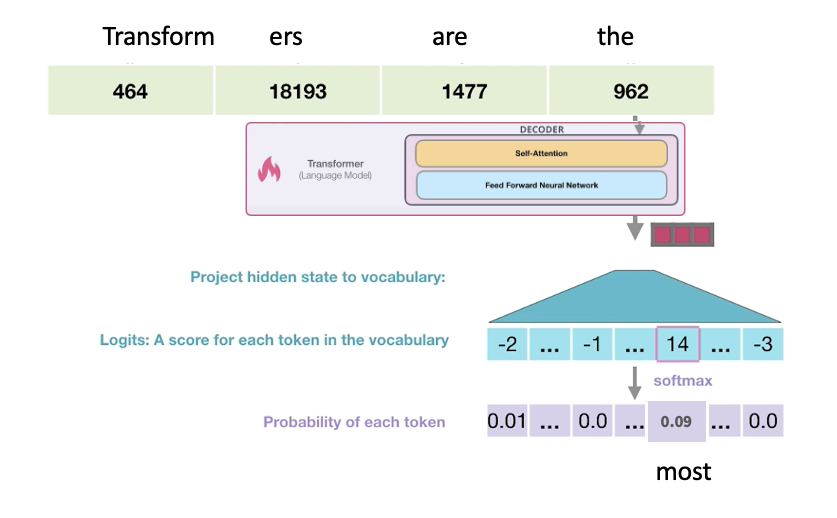

In [ ]:
import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
import torch

iterations = []
n_steps = 20
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,The train has left the,station (62.89%),train (2.69%),city (2.14%),depot (1.15%),track (0.88%)
1,The train has left the station,and (23.12%),", (16.75%)",. (13.63%),at (8.56%),in (3.17%)
2,The train has left the station and,is (24.36%),the (6.24%),has (3.89%),will (3.81%),it (3.15%)
3,The train has left the station and is,now (14.56%),heading (8.97%),expected (8.01%),headed (5.17%),being (3.03%)
4,The train has left the station and is now,heading (14.46%),on (6.60%),in (4.69%),waiting (4.61%),headed (4.49%)
5,The train has left the station and is now heading,to (21.91%),towards (14.57%),back (13.57%),for (8.81%),south (6.43%)
6,The train has left the station and is now heading to,the (25.38%),a (5.44%),London (1.27%),another (1.20%),an (1.11%)
7,The train has left the station and is now heading to the,airport (3.46%),city (2.53%),west (2.34%),east (1.90%),station (1.77%)
8,The train has left the station and is now heading to the airport,. (53.07%),", (10.32%)",in (6.27%),","" (2.73%)",at (2.54%)
9,The train has left the station and is now heading to the airport.,\n (35.64%),The (10.30%),It (4.70%),We (3.09%),There (2.60%)


In [ ]:
tokenizer.convert_ids_to_tokens(input[0])

['Transform', 'ers', 'Ġare', 'Ġthe']

## Breathe meaning into numbers (Embedding)

In [ ]:
# This is the embedding matrix of the model
model.transformer.wte # Dimensions are: (Number of tokens in vocabulary, dimension of model)

Embedding(50257, 768)

In [ ]:
import torch

In [ ]:
text = "Transformers are the"
# Tokenize the input string
input = tokenizer.encode(text, return_tensors="pt")


# activate beam search and early_stopping
beam_output = model.generate(
    input,  
    max_length=100, 
    num_beams=5, 
    no_repeat_ngram_size=2,
    early_stopping=True
)

# Run the model
print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
Transformers are the same as in the original game.

In the game, you will be able to choose from a variety of different types of weapons and armor. You will also have the option to customize your character to your liking. In addition to the weapons, there are a number of other items that you can equip. These items can be found in various locations around the world, such as:


In [ ]:
import torch

input_ids = tokenizer.encode("Transformers are the", return_tensors='pt')

# Generate the logits for the input text
with torch.no_grad():
    logits, _ = model(input_ids)

# Access the logits for the last token of the input text
last_token_logits = logits[0][-1]

# Display the logits
print(last_token_logits)

l


In [ ]:
import torch

# Encode the input text
input_ids = torch.tensor(tokenizer.encode("The train left the")).unsqueeze(0)  # Batch size 1

# Get the logits of the last token
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs[0][0, -1, :]

# Get the predicted token
predicted_index = torch.argmax(logits).item()
predicted_token = tokenizer.decode([predicted_index])

# Get the probability of all logits
probabilities = torch.softmax(logits, dim=0)


# Print the logits of the last token
print("Logits of the Last Token:", logits)

# Print the probability of all logits
print("Probabilities of All Logits:", probabilities)

# Print the predicted token
print("Predicted Token:", predicted_token)

# Get the probability of the predicted token
predicted_probability = probabilities[predicted_index].item()

# Print the probability of the predicted token
print("Probability of the Predicted Token:", predicted_probability)



Logits of the Last Token: tensor([ -99.3503,  -97.7980, -100.5724,  ..., -101.8007, -103.0647,
         -98.6136])
Probabilities of All Logits: tensor([9.8832e-08, 4.6674e-07, 2.9118e-08,  ..., 8.5251e-09, 2.4085e-09,
        2.0647e-07])
Predicted Token:  station
Probability of the Predicted Token: 0.5990238785743713


In [ ]:
next_token_logits = output.logits[0, -1, :]
next_token_probs = torch.softmax(next_token_logits, dim=-1)
print("Predicted Token Prob:", next_token_probs)

sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
print("Predicted Sorted Token Prob:", sorted_ids)


predicted_index = torch.argmax(next_token_probs).item()
predicted_token = tokenizer.decode([predicted_index])
print("Predicted Best Token Prob:", predicted_index)
print("Predicted Best Token:", predicted_token)

Predicted Token Prob: tensor([3.0540e-06, 2.4599e-06, 1.2898e-08,  ..., 2.2478e-08, 2.0694e-07,
        2.7212e-06])
Predicted Sorted Token Prob: tensor([13160,   262,   973,  ...,   191,   179, 36173])
Predicted Best Token Prob: 13160
Predicted Best Token:  composed
